In [ ]:
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import models
from keras import layers
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Dropout, Dense, Flatten, concatenate
from keras.models import Model
from keras import Input
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt    
%matplotlib inline
import numpy as np
import os
import glob
import cv2

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

! mkdir train_dir
! unzip '/content/gdrive/MyDrive/Training_Waiving' -d train_dir

mkdir: cannot create directory ‘train_dir’: File exists
Archive:  /content/gdrive/MyDrive/Training_Waiving.zip
   creating: train_dir/Training/
  inflating: train_dir/Training/other_0.avi  
  inflating: train_dir/Training/other_1.avi  
  inflating: train_dir/Training/other_10.avi  
  inflating: train_dir/Training/other_11.avi  
  inflating: train_dir/Training/other_12.avi  
  inflating: train_dir/Training/other_13.avi  
  inflating: train_dir/Training/other_14.avi  
  inflating: train_dir/Training/other_15.avi  
  inflating: train_dir/Training/other_16.avi  
  inflating: train_dir/Training/other_17.avi  
  inflating: train_dir/Training/other_18.avi  
  inflating: train_dir/Training/other_19.avi  
  inflating: train_dir/Training/other_2.avi  
  inflating: train_dir/Training/other_20.avi  
  inflating: train_dir/Training/other_21.avi  
  inflating: train_dir/Training/other_22.avi  
  inflating: train_dir/Training/other_23.avi  
  inflating: train_dir/Training/other_24.avi  
  inflating: 

In [ ]:
video_directory="/content/train_dir/Training"
videos=os.listdir(video_directory)
label=[]
for i in videos:
    if "other_" in i:
        label.append(0)
    else: 
        label.append(1)
       
videos=pd.DataFrame(videos,label).reset_index()
videos.columns=["labels","video_name"]

# 40% videos for validation and 60% for training
other=videos.loc[videos["labels"]==0,]
waiving=videos.loc[videos["labels"]==1,]

other_range=np.arange(len(other))
waiving_range=np.arange(len(waiving))
np.random.seed(12)
np.random.shuffle(other_range)
np.random.shuffle(waiving_range)

waiving=waiving.iloc[waiving_range,]
other=other.iloc[other_range,]

train_waiving=waiving.iloc[:36,]
train_other=other.iloc[:24,]
valid_waiving=waiving.iloc[36:,]
valid_other=other.iloc[24:,]

train_set=train_waiving.append(train_other)
valid_set=valid_waiving.append(valid_other)

train_set=train_set.reset_index().drop("index",axis=1)
valid_set=valid_set.reset_index().drop("index",axis=1)
train_set

,labels,video_name
0,1,waving_16.avi
1,1,waving_50.avi
2,1,waving_47.avi
3,1,waving_26.avi
4,1,waving_10.avi
5,1,waving_4.avi
6,1,waving_46.avi
7,1,waving_32.avi
8,1,waving_37.avi
9,1,waving_48.avi


In [ ]:

train_label=train_set["labels"]
valid_label=valid_set["labels"]
print(len(valid_set))
print(len(train_label))


40
60


In [ ]:
# !rm -rf frame_valid
# !rm -rf frame_train

In [ ]:
# ! mkdir frame_dir
! mkdir frame_train
! mkdir frame_valid

mkdir: cannot create directory ‘frame_train’: File exists
mkdir: cannot create directory ‘frame_valid’: File exists


In [ ]:
#fuction gets the video and save the frames of videos to .jpg format
def get_frames(dataset, dest_path):
    for i in np.arange(len(dataset)):
          video_name=dataset.video_name[i]
          video_path=os.path.join(video_directory,video_name)
          file_name = video_path.split('.')[0].split('/')[-1]
          cap= cv2.VideoCapture(video_path)
          total_frames = int(cap.get(7))
          frame_rate = cap.get(5)
          # print(file_name,total_frames,frame_rate)
          frame_distance = total_frames//10
          
          count=0
          frame_count=0
          for i in range (total_frames): #iterating over all the frames of the video.
              ret, frame = cap.read()
              if ret ==False:  # Checking if the frame is missing, and if missing, we take the previous frame
                  frame = f_prev
              elif ret==True:
                  f_prev =frame
              frame_count +=1
              if ((frame_count ==(frame_distance)) and (count<10)):
                  frame_count = 0
                  cv2.imwrite(dest_path+'/'+file_name+'_'+ str(count)+".jpg",frame)
                  count +=1
    cap.release()
    return print("All frames written in the  "+dest_path)

In [ ]:
frame_train='/content/frame_train'
frame_valid='/content/frame_valid'
get_frames(train_set,frame_train)
get_frames(valid_set,frame_valid)
print(len(os.listdir(frame_valid)))

All frames written in the  /content/frame_train
All frames written in the  /content/frame_valid
400


In [ ]:
img_high=200
img_width=200
frame_no_video=10

In [ ]:
def get_train_data(file_name):
    training = []
    frames_to_select=[]
    for i , filename in enumerate(glob.glob(file_name)):

        image = cv2.imread(filename)
        img = cv2.resize(image, dsize=(img_high,img_width), interpolation=cv2.INTER_CUBIC)
        # normalizing the pixel value
        img = img/255
        training.append(img)
    return training


In [ ]:
training = get_train_data(frame_train + '/*.jpg')
validation = get_train_data(frame_valid + '/*.jpg')

In [ ]:
x_train=np.array(training)
x_valid=np.array(validation)
y_train= np.array(train_label)
y_valid=np.array(valid_label)

In [ ]:
x_train=x_train.reshape(x_train.shape[0]//10,10,200, 200, 3)
x_valid=x_valid.reshape(x_valid.shape[0]//10,10,200, 200, 3)
print(x_train.shape)
print(x_valid.shape)

(60, 10, 200, 200, 3)
(40, 10, 200, 200, 3)


In [ ]:
# 3D Convolutional Model:
input_model=Input(shape=(10,200,200,3))
layer=Conv3D(64,(3,3,3),activation='relu')(input_model)
layer=MaxPooling3D((2,2,2))(layer)
layer=Conv3D(32,(3,3,3),activation='relu')(layer)
layer=MaxPooling3D((2,2,2))(layer)
layer=BatchNormalization()(layer)
layer=Flatten()(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dropout(0.3)(layer)
layer=Dense(64,activation='relu')(layer)
layer=Dense(32,activation='relu')(layer)
layer_output=Dense(1,activation='sigmoid')(layer)

model=Model(input_model,layer_output)

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10, 200, 200, 3)] 0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 8, 198, 198, 64)   5248      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 4, 99, 99, 64)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 2, 97, 97, 32)     55328     
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 1, 48, 48, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1, 48, 48, 32)     128       
_________________________________________________________________
flatten_6 (Flatten)          (None, 73728)             0   

In [ ]:
# Conv3d model training:
from keras import optimizers
import keras
from keras.callbacks import ModelCheckpoint
path = F"/content/gdrive/MyDrive/model8.h5" 
checkpoint = ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=0.001),metrics=['acc']) 
history=model.fit(x_train,y_train,batch_size=5,epochs=10,
               validation_data=(x_valid,y_valid),callbacks=checkpoint)  

Epoch 1/10
12/12 [==============================] - 2s 160ms/step - loss: 3.0806 - acc: 0.4519 - val_loss: 3.1548 - val_acc: 0.6000

Epoch 00001: val_loss improved from inf to 3.15478, saving model to /content/gdrive/MyDrive/model8.h5
Epoch 2/10
12/12 [==============================] - 2s 140ms/step - loss: 1.3103 - acc: 0.7122 - val_loss: 2.5107 - val_acc: 0.4000

Epoch 00002: val_loss improved from 3.15478 to 2.51073, saving model to /content/gdrive/MyDrive/model8.h5
Epoch 3/10
12/12 [==============================] - 2s 139ms/step - loss: 0.7541 - acc: 0.6377 - val_loss: 0.9162 - val_acc: 0.6000

Epoch 00003: val_loss improved from 2.51073 to 0.91615, saving model to /content/gdrive/MyDrive/model8.h5
Epoch 4/10
12/12 [==============================] - 2s 140ms/step - loss: 0.4348 - acc: 0.7946 - val_loss: 3.2825 - val_acc: 0.6000

Epoch 00004: val_loss did not improve from 0.91615
Epoch 5/10
12/12 [==============================] - 2s 139ms/step - loss: 0.1262 - acc: 0.9445 - val_lo

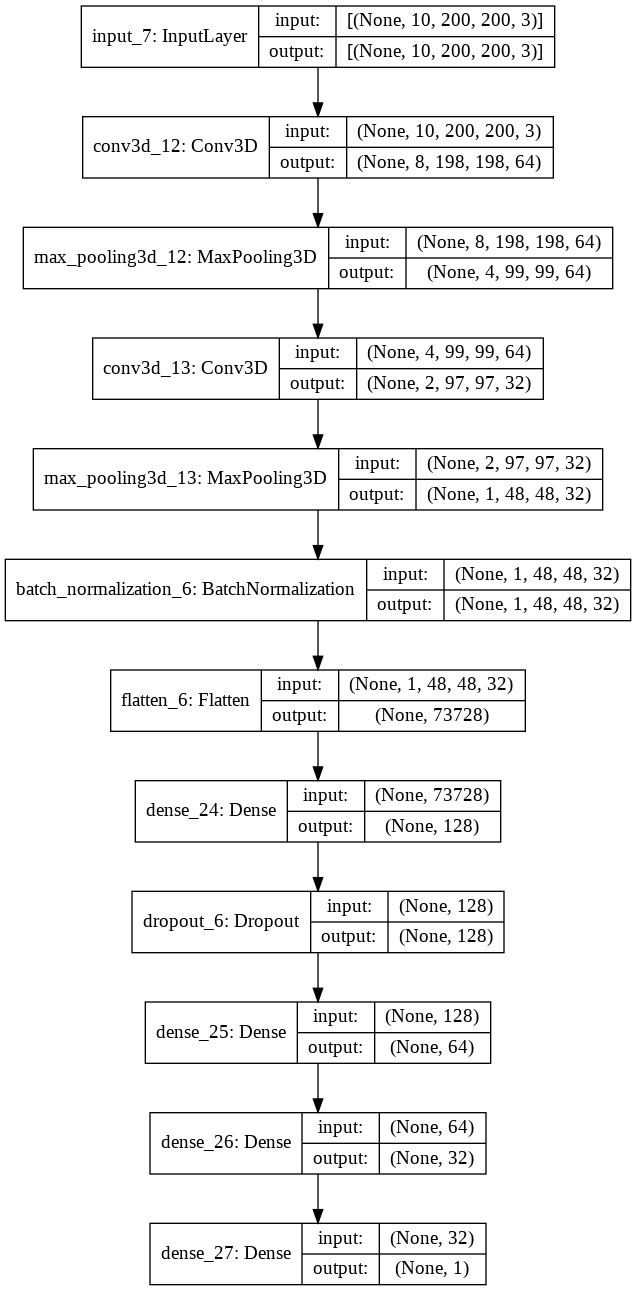

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

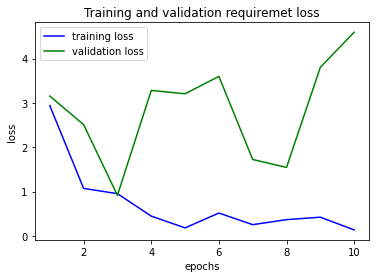

In [ ]:
epochs = range(1,11)
plt.plot(epochs, history.history['loss'], 'b', label = 'training loss')
plt.plot(epochs, history.history['val_loss'], 'g', label = 'validation loss')
plt.title('Training and validation requiremet loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()

In [ ]:
! mkdir test_dir
! unzip '/content/gdrive/MyDrive/Test_Waiving.zip' -d test_dir

mkdir: cannot create directory ‘test_dir’: File exists
Archive:  /content/gdrive/MyDrive/Test_Waiving.zip
replace test_dir/Test_Waiving/Test_Waiving/other_0.avi? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! mkdir  frames_test

In [ ]:
video_directory='/content/test_dir/Test_Waiving/Test_Waiving'
frames_test='/content/frames_test'

In [ ]:
videos=os.listdir(video_directory)
test_label=[]
for i in videos:
    if "other_" in i:
        test_label.append(0)
    else: 
        test_label.append(1)
print(len(test_label))

videos=pd.DataFrame(videos,test_label).reset_index()
videos.columns=["test_label","video_name"]

# 40% videos for validation and 60% for training
other=videos.loc[videos["test_label"]==0,]
waiving=videos.loc[videos["test_label"]==1,]

test_set=other.append(waiving)

test_set

6


,test_label,video_name
0,0,other_1.avi
2,0,other_0.avi
1,1,waiving_1.avi
3,1,waiving_0.avi
4,1,waiving_2.avi
5,1,waiving_3.avi


In [ ]:
#save the frames of all videos
get_frames(test_set,frames_test)

All frames written in the  /content/frames_test


In [ ]:
testing = get_train_data(frames_test + '/*.jpg')

In [ ]:
X_test = np.array(testing)
y_test = np.array(test_label)
X_test=X_test.reshape(X_test.shape[0]//10,10,200, 200, 3)
print(X_test.shape)
print(y_test.shape)

(6, 10, 200, 200, 3)
(6,)


In [ ]:
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1/1 [==============================] - 0s 201ms/step - loss: 2.5724 - acc: 0.6667
acc: 66.67%
